# Algoritmus SIMPLE pro Navierovy-Stokesovy rovnice

In [1]:
import Base.+, Base.-, Base.*
using PyPlot

In [2]:
include("cartesianmesh.jl");

In [3]:
type Field{T}
    value 
    mesh
    boundarycondition
end

In [4]:
typealias ScalarField Field{Float64};
typealias VectorField Field{Vec2d};

In [5]:
ScalarField(m :: CartesianMesh, bc) = Field{Float64}(zeros(m.nx*m.ny), m, bc);
VectorField(m :: CartesianMesh, bc) = Field{Vec2d}(zeros(Vec2d, m.nx*m.ny), m, bc);

In [6]:
asmatrix(f::ScalarField) = reshape(f.value, (f.mesh.nx,f.mesh.ny) );

function asmatrix(f::VectorField)
    m = zeros(f.mesh.nx, f.mesh.ny, 2)
    for j=1:f.mesh.ny, i=1:f.mesh.nx
        m[i,j,:] = f.value[i+(j-1)*f.mesh.nx]
    end
    return m
end;

In [7]:
type Equation{T}
    A
    x
    b
end

In [8]:
-(eq::Equation) = Equation(-eq.A, eq.x, -eq.b);

-{T}(eq::Equation{T}, b::Array{T,1}) = Equation{T}(eq.A, eq.x, eq.b + b);

+{T}(eq::Equation{T}, b::Array{T,1}) = Equation{T}(eq.A, eq.x, eq.b - b);

function +{T}(eq1::Equation{T}, eq2::Equation{T})
    assert(eq1.x == eq2.x)
    Equation{T}( eq1.A + eq2.A, eq1.x, eq1.b + eq2.b )
end

*{T}(a::Float64, eq::Equation{T}) = Equation{T}(a*eq.A, eq.x, a*eq.b);

In [9]:
Ac(eq::Equation) = diag(eq.A);

function H(eq::Equation)
    res = copy(eq.b)
    I,J,V = findnz(eq.A)
    for ijv in zip(I,J,V)
        i,j,v = ijv
        if i!=j
            res[i] -= v * eq.x[j]
        end
    end
    return res
end

H (generic function with 1 method)

In [10]:
function relax!(eqn::Equation, α)
    D = diag(eqn.A)
    for i=1:length(D) 
        eqn.A[i,i] /= α
    end
    eqn.b += (1-α)/α * D .* eqn.x
end;

In [11]:
function solve!(eqn::Equation{Float64})
    x = eqn.A \ eqn.b
    for i in eachindex(eqn.x)
        eqn.x[i] = x[i]
    end
end;

In [12]:
function solve!(eqn::Equation{Vec2d})
    b = zeros(length(eqn.b),2)
    for i=1:length(eqn.b)
        b[i,:] = eqn.b[i]
    end
    
    x = eqn.A \ b

    for i in eachindex(eqn.x)
        eqn.x[i] = x[i,:]
    end

end;

In [13]:
#
# α uf + β (uf-u1) / Δ = g   => (αΔ + β) uf = gΔ + β u1
#
type Robin
    α
    β
    g
end

# uf = c1 + c2 * u1 = ...
bndcoeffs(uin, Δ, bc::Robin) = ( bc.g*Δ / (bc.α*Δ + bc.β), bc.β / (bc.α*Δ + bc.β) );

function bndvalue(uin, Δ, bc::Robin)
    c1, c2 = bndcoeffs(uin, Δ, bc)
    c1 + c2*uin
end

# dudn = (uf - u1) / Δ = g/(αΔ + β) - α/(β + αΔ) * u1
ddncoeffs(uin, Δ, bc::Robin) = ( bc.g / (bc.α*Δ + bc.β), -bc.α / (bc.α*Δ + bc.β) );


In [14]:
Dirichlet(value) = Robin(1.0, 0.0, value);
Neumann(value) = Robin(0.0, 1.0, value);

In [15]:
function createfields(msh)
    U = VectorField(msh, Dict( 
            "top"=>Dirichlet(Vec2d(1,0)), 
            "left"=>Dirichlet(Vec2d(0,0)), 
            "right"=>Dirichlet(Vec2d(0,0)), 
            "bottom"=>Dirichlet(Vec2d(0,0)) 
            ));
        
    p = ScalarField(msh, Dict( 
            "top"=>Neumann(0.0), 
            "left"=>Neumann(0.0), 
            "right"=>Neumann(0.0), 
            "bottom"=>Neumann(0.0)
            ));
    return (U,p)
end;

In [16]:
function laplace{T}(ν, u::Field{T})
    mesh = u.mesh
    dims = (mesh.nx, mesh.ny)
    n  = prod(dims)
    A = spzeros(n,n)
    b = zeros(u.value)

    
    for f in internalfaces(mesh)
        owner, neigh = f.owner, f.neigh
        
        νf = (ν[owner]+ν[neigh]) / 2.0
        
        co = cell(mesh, owner)
        cn = cell(mesh, neigh)
        
        g = νf * norm(f.s) / norm(cn.x-co.x)

        A[owner, owner] -= g / co.vol
        A[owner, neigh] += g / co.vol
            
        A[neigh, owner] += g / cn.vol
        A[neigh, neigh] -= g / cn.vol
    end
    
    for patch in patches(mesh)

        bc = u.boundarycondition[ name(patch) ]
        for f in boundaryfaces(patch)
            owner = f.owner
            co = cell(mesh, owner)
            
            Δ = norm(f.x - co.x)
            νf = ν[owner]
            
            c1,c2 = ddncoeffs(u.value[owner], Δ, bc)
            A[owner,owner] += νf * c2 * norm(f.s) / co.vol
            b[owner] -= νf * c1 * norm(f.s) / co.vol
        end
    end
    
    Equation{T}(A, u.value, b)
end

laplace(u) = laplace(ones(u.mesh.nx*u.mesh.ny), u)

laplace (generic function with 2 methods)

In [17]:
m3 = CartesianMesh(3,3);
U,p = createfields(m3);

In [18]:
UEqn = laplace(U);
solve!(UEqn);

In [19]:
asmatrix(U)[:,:,1]

3×3 Array{Float64,2}:
 0.0357143  0.15  0.464286
 0.0642857  0.25  0.635714
 0.0357143  0.15  0.464286

In [20]:
function grad(p::ScalarField)
    mesh = p.mesh
    dp = zeros(Vec2d,length(p.value))
    
    for f in internalfaces(mesh)
        owner = f.owner
        neigh = f.neigh
        
        pf = (p.value[owner] + p.value[neigh]) / 2.0
        
        dp[owner] += pf * f.s
        dp[neigh] -= pf * f.s
    end

    for patch in patches(mesh)
        bc = p.boundarycondition[ name(patch) ]
        for f in boundaryfaces(patch)
            owner = f.owner
            co = cell(mesh, owner)
            Δ = norm(f.x - co.x)
            pf = bndvalue(p.value[owner], Δ, bc)
            dp[owner] += pf * f.s
        end
    end
    
    for c in cells(mesh)
        dp[c.id] /= c.vol
    end
    
    return dp
end;

In [21]:
function ∇(U::VectorField)
    mesh = U.mesh
    d = zeros(length(U.value))
    
    for f in internalfaces(mesh)
        owner = f.owner
        neigh = f.neigh
        
        Uf = (U.value[owner] + U.value[neigh]) / 2.0
        
        d[owner] += dot(Uf, f.s)
        d[neigh] -= dot(Uf, f.s)
    end

    for patch in patches(mesh)
        bc = U.boundarycondition[ name(patch) ]
        for f in boundaryfaces(patch)
            owner = f.owner
            co = cell(mesh, owner)
            Δ = norm(f.x - co.x)
            Uf = bndvalue(U.value[owner], Δ, bc)
            d[owner] += dot(Uf, f.s)
        end
    end
    
    for c in cells(mesh)
        d[c.id] /= c.vol
    end
    
    return d
end;

## Stokesuv problem (test)

In [22]:
function cavity_stokes(ν, mesh)
    
    U,p = createfields(mesh);

    α = 0.7
    β = 0.3

    for iter = 0:50
    
        UOld, pOld = copy(U.value), copy(p.value)
    
        UEqn = (-ν)*laplace(U)

        relax!(UEqn, α)
    
        solve!(UEqn + grad(p))
    
        ra = 1 ./ Ac(UEqn);
    
        UBar = VectorField( ra .* H(UEqn), U.mesh, U.boundarycondition);
    
        pEqn = laplace(ra, p) - ∇(UBar);
        pEqn.A[1,1] -= 1/(p.mesh.Δx*p.mesh.Δy)
        solve!(pEqn)
    
        p.value = (1-β) * pOld + β * p.value
        U.value = UBar.value - ra .* grad(p)
    
        if rem(iter,5)==0
            nxny = U.mesh.nx*U.mesh.ny
            pRez = norm(pOld - p.value) / nxny
            URez = norm(UOld - U.value) / nxny
            println(iter, "\t", pRez, "\t", URez)
        end
    end
    
    return (U, p)
end

cavity_stokes (generic function with 1 method)

In [23]:
ν = 0.01;
msh25 = CartesianMesh(25,25);

In [24]:
U, p = cavity_stokes(ν, msh25);

0	0.003954386650172478	0.0031633014957489253
5	0.0008056242457412445	0.0006441976603973865
10	0.00017451214787952626	0.00026851516499101004
15	0.00016278778503933032	0.00015566140539053025
20	7.78991484908024e-5	0.00010629255136366733
25	2.663636409865826e-5	7.613901133124296e-5
30	6.477468568530207e-6	5.615661004074861e-5
35	1.24030079781303e-6	4.225099116382523e-5
40	6.282254802240837e-7	3.221046544787988e-5
45	6.019827881723708e-7	2.4782509432768523e-5
50	6.034119431996541e-7	1.91952338374779e-5


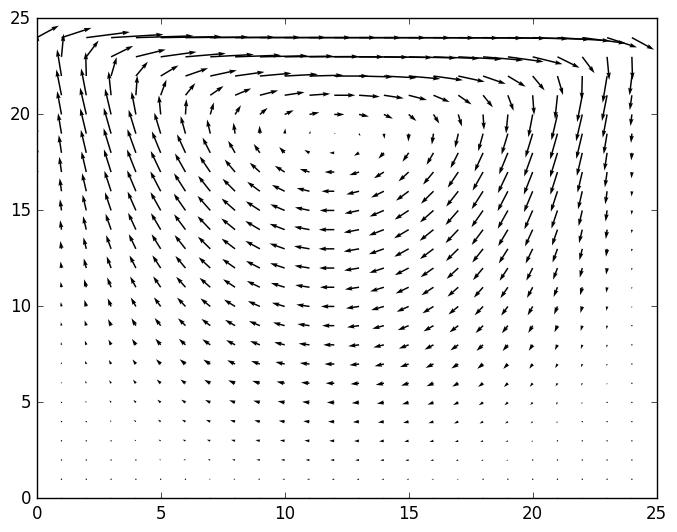

In [25]:
U_s25 = copy(asmatrix(U));
quiver(U_s25[:,:,1]', U_s25[:,:,2]');

## Navierovy-Stokesovy rovnice

In [26]:
function ∇{T}(V::VectorField, U::Field{T})
    mesh = U.mesh
    dims = (mesh.nx, mesh.ny)
    n  = prod(dims)
    A = spzeros(n,n)
    b = zeros(U.value)

    
    for f in internalfaces(mesh)
        owner, neigh = f.owner, f.neigh
        co = cell(mesh, owner)
        cn = cell(mesh, neigh)
        
        Vf = (V.value[owner]+V.value[neigh]) / 2.0
        ϕ  = dot(Vf, f.s)
        
        # upwind flux = max(phi,0) * U[owner] + min(phi,0) * U[neigh]
        α = max(ϕ, 0.0)
        β = min(ϕ, 0.0)
        
        A[owner, owner] += α / co.vol
        A[owner, neigh] += β / co.vol
            
        A[neigh, owner] -= α / cn.vol
        A[neigh, neigh] -= β / cn.vol
    end
  
    for patch in patches(mesh)

        bc = U.boundarycondition[ name(patch) ]
        vbc= V.boundarycondition[ name(patch) ]
        
        for f in boundaryfaces(patch)
            owner = f.owner
            co = cell(mesh, owner)
            
            Δ = norm(f.x - co.x)
            Vf = bndvalue(V.value[owner], Δ, vbc)
            ϕ  = dot(Vf, f.s)
            
            α = max(ϕ, 0.0)
            β = min(ϕ, 0.0)

            c1, c2 = bndcoeffs(U.value[owner], Δ, bc)
            # uf = c1 + c2 * u1
            A[owner,owner] += (α + β*c2) / co.vol
            b[owner] -= β*c1 / co.vol
        end
    end
    
    Equation{T}(A, U.value, b)
end;

In [27]:
function cavity_ns(ν, mesh)

    U,p = createfields(mesh);

    α = 0.7
    β = 0.3

    for iter = 0:50
    
        UOld, pOld = copy(U.value), copy(p.value)
    
        UEqn = ∇(U,U) + (-ν)*laplace(U)

        relax!(UEqn, α)
    
        solve!(UEqn + grad(p))
    
        ra = 1 ./ Ac(UEqn);
    
        UBar = Field{Vec2d}( ra .* H(UEqn), U.mesh, U.boundarycondition);
    
        pEqn = laplace(ra, p) - ∇(UBar);
        pEqn.A[1,1] -= 1/(p.mesh.Δx*p.mesh.Δy)
        solve!(pEqn)
    
        p.value = (1-β) * pOld + β * p.value
        U.value = UBar.value - ra .* grad(p)
    
        if rem(iter,5)==0
            nxny = U.mesh.nx*U.mesh.ny
            pRez = norm(pOld - p.value) / nxny
            URez = norm(UOld - U.value) / nxny
            println(iter, "\t", pRez, "\t", URez)
        end
    end
    
    return (U,p)
end

cavity_ns (generic function with 1 method)

In [28]:
ν = 0.01;
msh25 = CartesianMesh(25,25);
U,p = cavity_ns(ν, msh25);

0	0.003954386650172478	0.0031633014957489253
5	0.0009314145959925842	0.0005813130259156928
10	0.00013541367594446414	0.00025482292700571165
15	0.0001784570061217931	0.00015116094560003838
20	0.00010600247145212179	0.00010605954998718344
25	4.444015598353953e-5	7.860745464884472e-5
30	1.75034609490482e-5	5.993543686387687e-5
35	9.872183918249541e-6	4.656325348232292e-5
40	7.533115091106704e-6	3.6621142093288105e-5
45	6.340685538901695e-6	2.9019128807815896e-5
50	5.372363192198863e-6	2.3093739343419976e-5


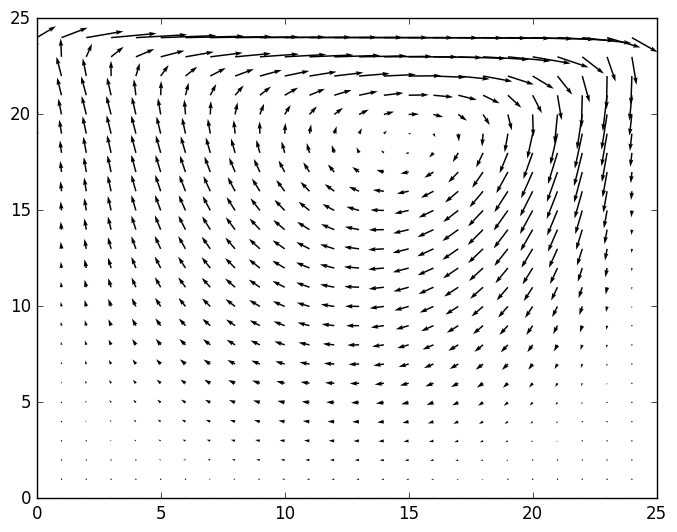

In [29]:
U_ns25 = copy(asmatrix(U));
quiver(U_ns25[:,:,1]', U_ns25[:,:,2]');

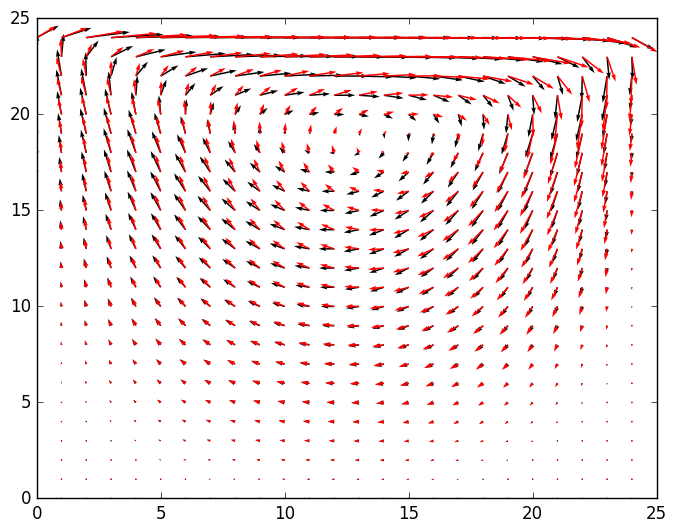

In [30]:
quiver(U_s25[:,:,1]', U_s25[:,:,2]');
quiver(U_ns25[:,:,1]', U_ns25[:,:,2]', color="red");

In [31]:
ν = 1.e-3;
msh50 = CartesianMesh(50,50);

In [32]:
U,p = cavity_stokes(ν, msh50);
U_s50 = copy(asmatrix(U));

0	0.0003937945717287575	0.0011611564177153371
5	0.0001067693511043803	0.00024052153119465044
10	1.0489250342796397e-5	0.00012036686861596977
15	1.7247658364141984e-5	7.951447626614588e-5
20	1.0324717758407268e-5	6.06972387474102e-5
25	4.226525501802655e-6	4.89877025326525e-5
30	1.4015841293482872e-6	4.086872842453536e-5
35	4.590570023027341e-7	3.489840490957183e-5
40	2.418933280770268e-7	3.0301242146274515e-5
45	2.229591949932636e-7	2.6639086524941736e-5
50	2.1747870263023835e-7	2.3646813695293057e-5


In [33]:
U,p = cavity_ns(ν, msh50);
U_ns50 = copy(asmatrix(U));

0	0.0003937945717287575	0.0011611564177153371
5	0.0001337404951031609	0.00017967420931574288
10	2.2222676578972052e-5	0.00010486143095497074
15	1.9053869882897907e-5	8.080573257940475e-5
20	1.688274663605772e-5	6.994942884190264e-5
25	1.250072086651074e-5	6.382292458282305e-5
30	1.0094698007501586e-5	5.962172127443129e-5
35	8.855471267011229e-6	5.592468280388012e-5
40	8.098191273679112e-6	5.2352628698924074e-5
45	7.515827468230783e-6	4.888573048737401e-5
50	6.988471962086046e-6	4.5519190316678015e-5


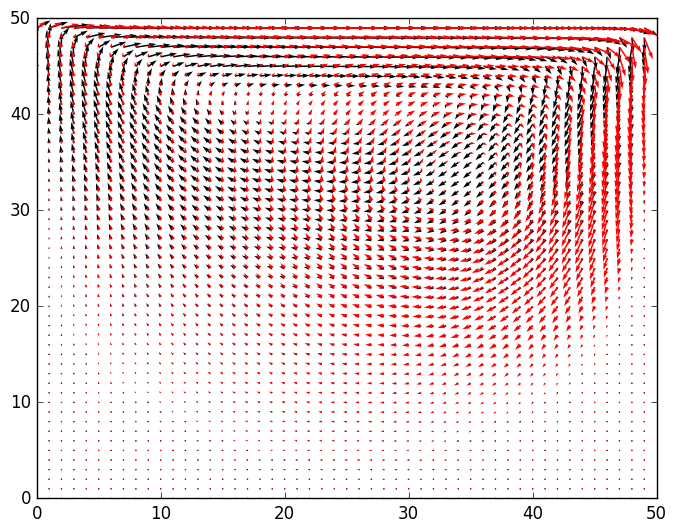

In [34]:
quiver(U_s50[:,:,1]', U_s50[:,:,2]');
quiver(U_ns50[:,:,1]', U_ns50[:,:,2]', color="red");

In [35]:
# Ψ_x = v, Ψ_y = - u

function streamfunction(U, Δx, Δy)
    Ψ1 = zeros(size(U,1),size(U,2))

    Ψ1[1,1] = 0.0
    for i=2:size(U,1)
        Ψ1[i,1] = Ψ1[i-1,1] + Δx * (U[i,1,2]+U[i-1,1,2])/2
    end
    for j=2:size(U,2)
        Ψ1[:,j] = Ψ1[:,j-1] - Δy * (U[:,j,1]+U[:,j-1,1])/2
    end

    Ψ2 = zeros(Ψ1)
    
    Ψ2[1,1] = 0.0
    for j=2:size(U,2)
        Ψ2[1,j] = Ψ2[1,j-1] - Δy * (U[1,j,1]+U[1,j-1,1])/2
    end
    for i=2:size(U,1)
        Ψ2[i,:] = Ψ2[i-1,:] + Δx * (U[i,:,2]+U[i-1,:,2])/2
    end
    
    Ψ = (Ψ1 + Ψ2) / 2
    
    #Ψ[end,end] = (Ψ[end-1,end]+Ψ[end,end-1]) / 2
    return Ψ
end

streamfunction (generic function with 1 method)

In [36]:
Ψ = streamfunction(U_ns50, 1/50, 1/50);

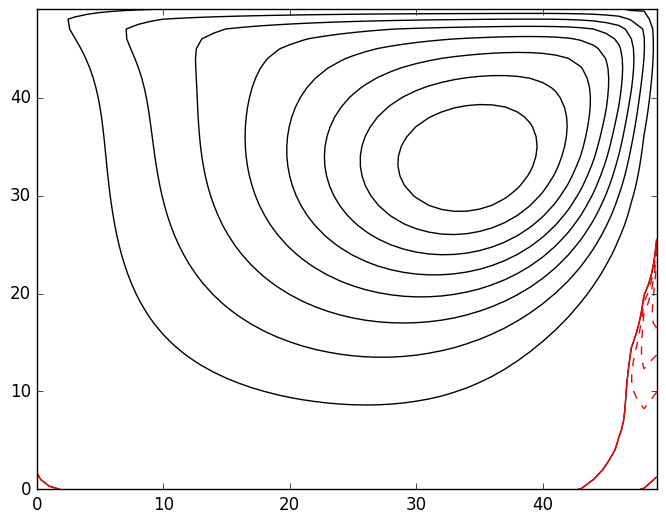

In [37]:
pos = linspace(0, maximum(Ψ), 10)
contour(Ψ', pos, colors="black");
neg = linspace(minimum(Ψ), 0, 5)
contour(Ψ', neg, colors="red");

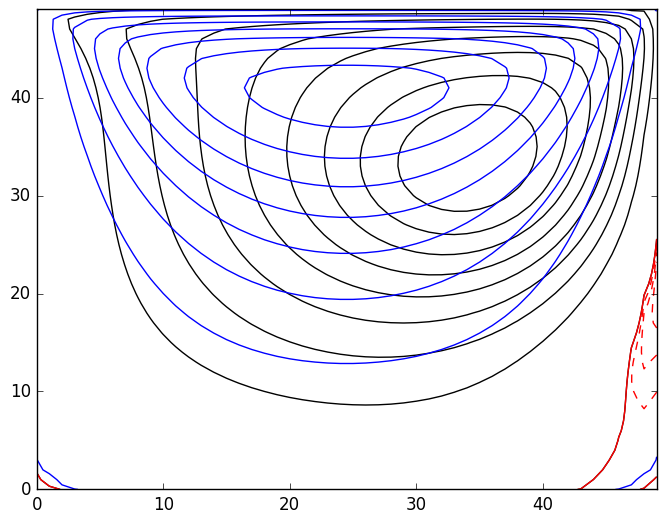

In [38]:
Ψs50 = streamfunction(U_s50, 1/50, 1/50);

pos = linspace(0, maximum(Ψ), 10)
contour(Ψ', pos, colors="black");
neg = linspace(minimum(Ψ), 0, 5)
contour(Ψ', neg, colors="red");

contour(Ψs50', colors="blue");